# Animal Influenza Emergence Risk Predictions
- Uses the Emergenet package to generate emergence risk scores for animal strains
- Collected animal HA and NA strains from January 1, 2020 - September 30, 2022
- Used qnets from `qnet_models/current_qnets/`

In [297]:
import os 
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import math
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')
from Bio import SeqIO

# linear model
import statsmodels.api as sm
import statsmodels.formula.api as smf

from emergenet import Enet, save_model, load_model
# from emergenet.emergenet import Enet, save_model, load_model
from quasinet.qnet import Qnet, qdistance, qdistance_matrix, membership_degree, save_qnet, load_qnet
from zedstat.textable import textable

In [314]:
# input: fasta file name, length to truncate each sequence, whether to represent strains as char arrays
# output: dataframe of sequences
def parse_fasta(file_name, trunc, seq_array = False):
    acc = []
    seq = []
    for record in SeqIO.parse(file_name, 'fasta'):
        if len(record.seq) < trunc:
            continue
        acc.append(record.id.split('|')[0])
        if seq_array:
            seq.append(np.array(record.seq[:trunc].upper()))
        else:
            seq.append(str(record.seq[:trunc].upper()))
    df = pd.DataFrame({'id':acc, 'sequence':seq})
    return df


# input: dataframe of sequences, number of samples
# output: array of nucleotide lists
def sequence_array(seq_df):
    seqs = seq_df['sequence'].values
    seq_lst = []
    for seq in seqs:
        seq_lst.append(seq)
    return np.array(seq_lst)


# input: name to call qnet, array of nucleotide lists, number of nucleotides
# output: save qnet as joblib
def train_save_qnet(name, seq_arr, num_nuc):
    myqnet = Qnet(feature_names=['x'+str(i) for i in np.arange(num_nuc)],n_jobs=1)
    myqnet.fit(seq_arr)
    save_qnet(myqnet, QNET_DIR + name + '.joblib')
    

# input: data, emergence and impact models
# output: data with emergence and impact predictions
def predict_irat(df, emergence_mod, impact_mod):
    df = df.rename(columns={'geometric_mean_risk':'Geometric_Mean',
                            'ha_risk':'HA_Avg_Qdist',
                            'na_risk':'NA_Avg_Qdist'})
    df['predicted_emergence_score'] = emergence_mod.predict(df)
    df['predicted_impact_score'] = impact_mod.predict(df)
    for i in range(len(df)):
        if df['Geometric_Mean'][i] > 0.3:
            df.at[i, 'predicted_emergence_score'] = 3.8
            df.at[i, 'predicted_impact_score'] = 4.45
    return df


# input: fasta file name, length to truncate each sequence
# output: dataframe of sequences (containing only name and accession)
def parse_fasta2(file_name, trunc):
    name = []
    acc = []
    subtype = []
    for record in SeqIO.parse(file_name, 'fasta'):
        if len(record.seq) < trunc:
            continue
        name.append(record.id.split('|')[0])
        acc.append(record.id.split('|')[4])
        subtype.append(record.id.split('|')[1][-4:])
    df = pd.DataFrame({'id':name, 'subtype':subtype, 'accession':acc})
    return df

## Predictions

In [299]:
DATA_DIR = 'raw_data/gisaid_animal/'
HUMAN_DATA_DIR = 'raw_data/gisaid_current/'
QNET_DIR = 'qnet_models/current_qnets/'
OUT_DIR = 'results/animal_predictions/'

NA_TRUNC = 449
HA_TRUNC = 550

FILES = ['h1n1', 'h1n2', 'h3n2', 'h5n1', 'h5n2', 'h5n6', 'h5n8', 'h7', 'h9n2']

In [ ]:
for FILE in tqdm(FILES):
    ha_qnet = load_model(QNET_DIR + FILE + '_ha.joblib')
    na_qnet = load_model(QNET_DIR + FILE + '_na.joblib')
    
    ha_df = parse_fasta(DATA_DIR + FILE + '_ha.fasta', HA_TRUNC)
    na_df = parse_fasta(DATA_DIR + FILE + '_na.fasta', NA_TRUNC)
    df = ha_df.merge(na_df, how='inner', on='id').rename(columns={'sequence_x':'ha', 'sequence_y':'na'})
    
    human_ha_df = parse_fasta(HUMAN_DATA_DIR + FILE + '_ha.fasta', HA_TRUNC, seq_array=True)
    human_na_df = parse_fasta(HUMAN_DATA_DIR + FILE + '_na.fasta', NA_TRUNC, seq_array=True)
    
    ha_emergence_risk = []
    ha_variance = []
    na_emergence_risk = []
    na_variance = []
    geometric_mean_risk = []

    for i in trange(len(df)):
        row = df.iloc[i]
        enet_ha = Enet(seq=row['ha'], seq_trunc_length=HA_TRUNC, random_state=42)
        enet_na = Enet(seq=row['na'], seq_trunc_length=NA_TRUNC, random_state=42)

        emergence_risk_score_ha, variance_ha = enet_ha.emergence_risk(seq_df=human_ha_df, qnet=ha_qnet, sample_size=100)
        emergence_risk_score_na, variance_na = enet_na.emergence_risk(seq_df=human_na_df, qnet=na_qnet, sample_size=100)

        ha_emergence_risk.append(emergence_risk_score_ha)
        ha_variance.append(variance_ha)
        na_emergence_risk.append(emergence_risk_score_na)
        na_variance.append(variance_na)
        geometric_mean_risk.append(math.sqrt(emergence_risk_score_ha * emergence_risk_score_na))

    df['ha_risk'] = ha_emergence_risk
    df['ha_variance'] = ha_variance
    df['na_risk'] = na_emergence_risk
    df['na_variance'] = na_variance
    df['geometric_mean_risk'] = geometric_mean_risk

    # save dataframe as csv
    os.makedirs(OUT_DIR, exist_ok=True)
    df.to_csv(OUT_DIR + FILE + '.csv', index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1484 [00:00<?, ?it/s]

## Scale Predictions with GLM

In [340]:
data = pd.read_csv('results/irat_average_qdistances.csv')
data = data.rename(columns={'Potential Emergence Estimate':'IRAT_Emergence_Score',
                            'Potential Impact Estimate':'IRAT_Impact_Score',
                            'Geometric Mean':'Geometric_Mean',
                            'HA Average Qdistance':'HA_Avg_Qdist',
                            'NA Average Qdistance':'NA_Avg_Qdist'})
# remove Yunnan and Netherlands outliers, and Duck strain
data = data[(data['HA_Avg_Qdist'] > 0) & (data['NA_Avg_Qdist'] > 0)].drop(labels=[10, 12], axis=0)

In [341]:
# IRAT_Emergence_Score ~ Geometric_Mean + HA_Avg_Qdist:NA_Avg_Qdist
formula1 = 'IRAT_Emergence_Score ~ Geometric_Mean + NA_Avg_Qdist:HA_Avg_Qdist'
mod1 = smf.glm(formula=formula1, data=data).fit()
print(mod1.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     IRAT_Emergence_Score   No. Observations:                   20
Model:                              GLM   Df Residuals:                       17
Model Family:                  Gaussian   Df Model:                            2
Link Function:                 identity   Scale:                         0.74617
Method:                            IRLS   Log-Likelihood:                -23.826
Date:                  Fri, 18 Nov 2022   Deviance:                       12.685
Time:                          21:05:25   Pearson chi2:                     12.7
No. Iterations:                       3   Pseudo R-squ. (CS):             0.7678
Covariance Type:              nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
In

In [342]:
# IRAT_Impact_Score ~ Geometric_Mean + HA_Avg_Qdist:NA_Avg_Qdist
formula2 = 'IRAT_Impact_Score ~ Geometric_Mean + NA_Avg_Qdist:HA_Avg_Qdist'
mod2 = smf.glm(formula=formula2, data=data).fit()
print(mod2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      IRAT_Impact_Score   No. Observations:                   20
Model:                            GLM   Df Residuals:                       17
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          1.0345
Method:                          IRLS   Log-Likelihood:                -27.093
Date:                Fri, 18 Nov 2022   Deviance:                       17.587
Time:                        21:05:26   Pearson chi2:                     17.6
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4584
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [343]:
df_merged = pd.DataFrame({})

for FILE in tqdm(FILES):
    ha_df = parse_fasta2(DATA_DIR + FILE + '_ha.fasta', HA_TRUNC)
    na_df = parse_fasta2(DATA_DIR + FILE + '_na.fasta', NA_TRUNC)
    # df1: metadata
    df1 = ha_df.merge(na_df, how='inner', on='id').drop(columns=['subtype_y'])
    df1.rename(columns={'subtype_x':'subtype','accession_x':'ha_accession', 'accession_y':'na_accession'}, inplace=True)
    # df2: predictions
    df2 = pd.read_csv(OUT_DIR + FILE + '.csv')
    df2 = predict_irat(df2, mod1, mod2)
    df2.to_csv(OUT_DIR + FILE + '.csv', index=False)
    # df3: merge df1 and df2
    df3 = df1.merge(df2, how='inner', on='id').drop_duplicates(subset=['id'])
    df3 = df3[df3['id'] != 'not_release_-_host_x_isolate_name_not_match']
    if len(df_merged) == 0:
        df_merged = df3
    else:
        df_merged = df_merged.append(df3, ignore_index=True)

df_merged.to_csv(OUT_DIR + 'combined_results.csv', index=False)

  0%|          | 0/9 [00:00<?, ?it/s]

## Results

In [344]:
df_merged.sort_values(by='Geometric_Mean', ascending=True).head(5)

,id,subtype,ha_accession,na_accession,ha,na,HA_Avg_Qdist,ha_variance,NA_Avg_Qdist,na_variance,Geometric_Mean,predicted_impact_score,predicted_emergence_score
218,A/swine/Missouri/A02524711/2020,H1N1,EPI1818121,EPI1818122,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,0.007931,0.00001,0.001876,0.000002,0.003857,6.631798,6.706662
142,A/swine/Wisconsin/A02479131/2020,H1N1,EPI1780098,EPI1780099,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,0.007945,0.00001,0.001876,0.000002,0.003860,6.631748,6.706601
157,A/swine/Missouri/A02479157/2020,H1N1,EPI1780243,EPI1780244,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,0.007954,0.00001,0.001876,0.000002,0.003863,6.631716,6.706560
165,A/swine/North_Carolina/A02479181/2020,H1N1,EPI1780419,EPI1780420,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,0.007931,0.00001,0.001885,0.000002,0.003866,6.631657,6.706486
124,A/swine/Missouri/A02479058/2020,H1N1,EPI1778732,EPI1778733,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,0.007931,0.00001,0.001885,0.000002,0.003866,6.631657,6.706486


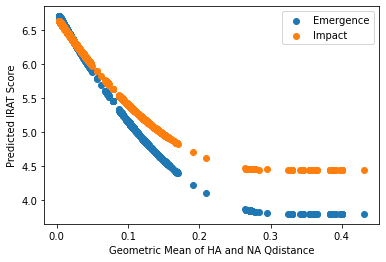

In [345]:
plt.scatter(df_merged['Geometric_Mean'], df_merged['predicted_emergence_score'], label='Emergence')
plt.scatter(df_merged['Geometric_Mean'], df_merged['predicted_impact_score'], label='Impact')
plt.xlabel('Geometric Mean of HA and NA Qdistance')
plt.ylabel('Predicted IRAT Score')
plt.legend();

In [346]:
df_merged.groupby(by='subtype').count()['id']

subtype
H1N1     938
H1N2     784
H3N2     826
H5N1    1598
H5N2      20
H5N6     140
H5N8    1382
H7N1       3
H7N2       1
H7N3      99
H7N5       1
H7N6       8
H7N7      11
H7N8       3
H7N9      17
H9N2     235
Name: id, dtype: int64